In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, decimate
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


In [26]:
def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

WZMACNIANIE SŁABYCH LINII – TYLKO BASELINE

Obliczam moving std (okno=25)...
Aplikuję bilateral filter (5, 25, 30)...


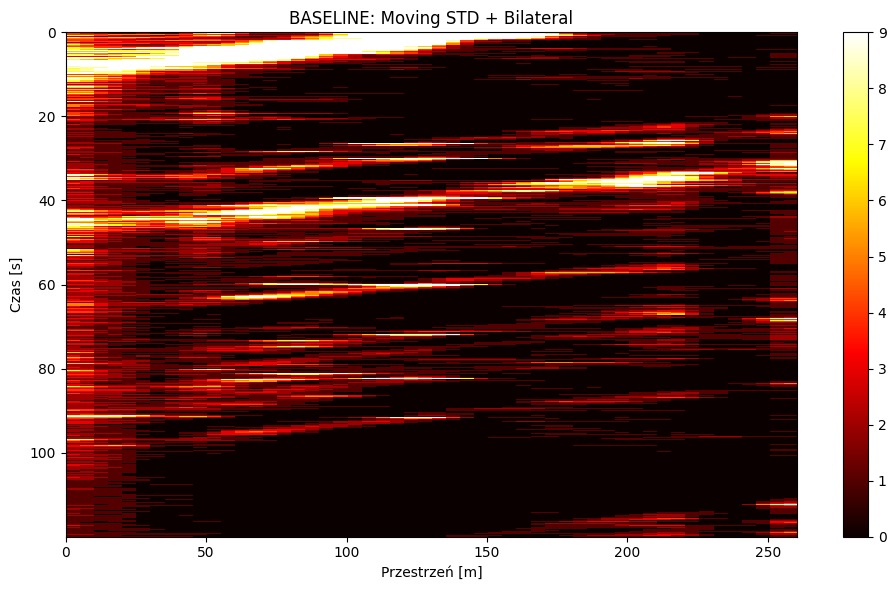

In [27]:
def uniform_filter_numpy(data, size):
    half = size // 2
    # replicate padding
    padded = np.pad(data, ((half, half), (0, 0)), mode='edge')
    
    # cumulative sum along time
    cumsum = np.cumsum(padded, axis=0)
    
    # okno przesuwne: suma z cumsum
    result = (cumsum[size:] - cumsum[:-size]) / size
    return result

def enhance_weak_lines(ts_start: str, ts_end: str, window_size=25):
    """
    ONLY BASELINE (moving std + bilateral)
    """
    pack = get_range(ts_start, ts_end)
    data = pack["data"]
    dt = pack["dt"]
    dx = pack["dx"]
    
    print("="*60)
    print("WZMACNIANIE SŁABYCH LINII – TYLKO BASELINE")
    print("="*60)
    
    import cv2
    from scipy.ndimage import uniform_filter
    from skimage import exposure, filters
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    
    time_axis = np.arange(data.shape[0]) * dt
    space_axis = np.arange(data.shape[1]) * dx
    
    # BASELINE: moving std
    print(f"\nObliczam moving std (okno={window_size})...")
    data_mean = uniform_filter_numpy(data, window_size)
    data_sq   = uniform_filter_numpy(data**2, window_size)
    base_std = np.sqrt(np.maximum(data_sq - data_mean**2, 0))
    
    # Bilateral
    print("Aplikuję bilateral filter (5, 25, 30)...")
    base_norm = ((base_std - np.min(base_std)) / (np.max(base_std) - np.min(base_std)) * 255).astype(np.uint8)
    base_bilateral = cv2.bilateralFilter(base_norm, d=5, sigmaColor=25, sigmaSpace=30).astype(np.float64)

    plt.figure(figsize=(10, 6))
    low, high = np.percentile(base_bilateral, [3, 97])
    
    plt.imshow(
        base_bilateral,
        aspect='auto',
        interpolation='none',
        norm=Normalize(vmin=low, vmax=high, clip=True),
        cmap='hot',
        extent=[0, space_axis[-1], time_axis[-1], 0]
    )
    
    plt.title("BASELINE: Moving STD + Bilateral")
    plt.ylabel("Czas [s]")
    plt.xlabel("Przestrzeń [m]")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    return {
        'baseline': base_bilateral,
        'dt': dt,
        'dx': dx
    }


# RUN
weak_lines = enhance_weak_lines(range3[0], range3[1], window_size=25)


In [28]:
def tune_moving_variance(ts_start: str, ts_end: str):
    """
    Test moving variance with different window sizes and smoothing
    """
    pack = get_range(ts_start, ts_end)
    data = pack["data"]
    dt = pack["dt"]
    dx = pack["dx"]
    
    print("="*60)
    print("TUNING: MOVING VARIANCE")
    print("="*60)
    
    import cv2
    
    time_axis = np.arange(data.shape[0]) * dt
    space_axis = np.arange(data.shape[1]) * dx
    
    # Test different window sizes
    window_sizes = [15, 20, 25, 30, 40, 50]
    
    print(f"\nTestuję różne rozmiary okna dla moving variance...")
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    axes = axes.flatten()
    
    results = {}
    
    for idx, window in enumerate(window_sizes):
        print(f"\n  [{idx+1}/{len(window_sizes)}] Okno = {window} próbek ({window*dt:.4f}s)")
        
        # Compute moving variance
        data_mean = uniform_filter_numpy(data, window)
        data_sq = uniform_filter_numpy(data**2, window)
        variance = data_sq - data_mean**2
        variance = np.maximum(variance, 0)
        
        results[f'var_window_{window}'] = variance
        
        # Plot
        ax = axes[idx]
        low, high = np.percentile(variance, [3, 97])
        
        im = ax.imshow(variance, aspect='auto', interpolation='none',
                       norm=Normalize(vmin=low, vmax=high, clip=True),
                       cmap='hot',
                       extent=[0, space_axis[-1], time_axis[-1], 0])
        
        ax.set_title(f"Variance: okno={window} ({window*dt:.4f}s)", fontsize=11, fontweight='bold')
        ax.set_ylabel("Czas [s]", fontsize=9)
        ax.set_xlabel("Przestrzeń [m]", fontsize=9)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("Które okno najlepsze? (15, 20, 25, 30, 40, 50)")
    print("="*60)
    
    # Now test smoothing methods on best window
    print("\n" + "="*60)
    print("TESTOWANIE WYGŁADZANIA (okno=25)")
    print("="*60)
    
    window_best = 25
    data_mean = uniform_filter_numpy(data, window_best)
    data_sq = uniform_filter_numpy(data**2, window_best)
    base_variance = data_sq - data_mean**2
    base_variance = np.maximum(base_variance, 0)
    
    fig2, axes2 = plt.subplots(3, 3, figsize=(24, 18))
    axes2 = axes2.flatten()
    
    # === Option 1: No smoothing ===
    opt1 = base_variance.copy()
    
    # === Option 2: Gaussian blur (light) ===
    print("\n[2/9] Gaussian blur (light)")
    opt2_norm = ((base_variance - np.min(base_variance)) / (np.max(base_variance) - np.min(base_variance)) * 255).astype(np.uint8)
    opt2 = cv2.GaussianBlur(opt2_norm, (3, 3), 0.5).astype(np.float64)
    
    # === Option 3: Gaussian blur (medium) ===
    print("[3/9] Gaussian blur (medium)")
    opt3 = cv2.GaussianBlur(opt2_norm, (5, 5), 1.0).astype(np.float64)
    
    # === Option 4: Bilateral filter (light) ===
    print("[4/9] Bilateral (15, 15)")
    opt4 = cv2.bilateralFilter(opt2_norm, d=3, sigmaColor=15, sigmaSpace=15).astype(np.float64)
    
    # === Option 5: Bilateral (medium) ===
    print("[5/9] Bilateral (25, 30)")
    opt5 = cv2.bilateralFilter(opt2_norm, d=5, sigmaColor=25, sigmaSpace=30).astype(np.float64)
    
    # === Option 6: Bilateral (stronger) ===
    print("[6/9] Bilateral (35, 40)")
    opt6 = cv2.bilateralFilter(opt2_norm, d=5, sigmaColor=35, sigmaSpace=40).astype(np.float64)
    
    # === Option 7: Median filter ===
    print("[7/9] Median filter (3x3)")
    opt7 = cv2.medianBlur(opt2_norm, 3).astype(np.float64)
    
    # === Option 8: Moving average (additional smoothing) ===
    print("[8/9] Moving average (10 próbek)")
    opt8 = uniform_filter_numpy(base_variance, 10)
    
    # === Option 9: Square root (less sharp) ===
    print("[9/9] Square root (łagodniejsze)")
    opt9_norm = (base_variance - np.min(base_variance)) / (np.max(base_variance) - np.min(base_variance) + 1e-10)
    opt9 = np.sqrt(opt9_norm) * np.max(base_variance)
    
    smoothing_methods = [
        (opt1, "Bez wygładzania"),
        (opt2, "Gaussian (3x3, σ=0.5)"),
        (opt3, "Gaussian (5x5, σ=1.0)"),
        (opt4, "Bilateral light (15,15)"),
        (opt5, "Bilateral medium (25,30)"),
        (opt6, "Bilateral strong (35,40)"),
        (opt7, "Median (3x3)"),
        (opt8, "Moving avg (10)"),
        (opt9, "Sqrt (łagodne)")
    ]
    
    for idx, (data_smooth, title) in enumerate(smoothing_methods):
        ax = axes2[idx]
        
        low, high = np.percentile(data_smooth, [3, 97])
        
        im = ax.imshow(data_smooth, aspect='auto', interpolation='none',
                       norm=Normalize(vmin=low, vmax=high, clip=True),
                       cmap='hot',
                       extent=[0, space_axis[-1], time_axis[-1], 0])
        
        ax.set_title(f"Variance + {title}", fontsize=10, fontweight='bold')
        ax.set_ylabel("Czas [s]", fontsize=9)
        ax.set_xlabel("Przestrzeń [m]", fontsize=9)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("WYBIERZ NAJLEPSZĄ KOMBINACJĘ:")
    print("="*60)
    print("1. Które okno? (15, 20, 25, 30, 40, 50)")
    print("2. Które wygładzanie? (1-9)")
    print("="*60)
    
    return {
        'results': results,
        'smoothing': smoothing_methods,
        'base_variance': base_variance,
        'dt': dt,
        'dx': dx
    }

# Run variance tuning
# variance_tuning = tune_moving_variance(range3[0], range3[1])

KROK 3: DETEKCJA LINII - POKAZUJĘ WSZYSTKO

Parametry:
  Rozmiar: 74999 × 52
  dt = 0.0016 s, dx = 5.11 m

[1/2] Przygotowanie obrazu...
  Threshold: 3.0
  Pikseli: 317463

[2/2] Detekcja linii...
  ✓ Wykryto 1632 linii

WYKRYTE LINIE (WSZYSTKIE, pierwsze 30):


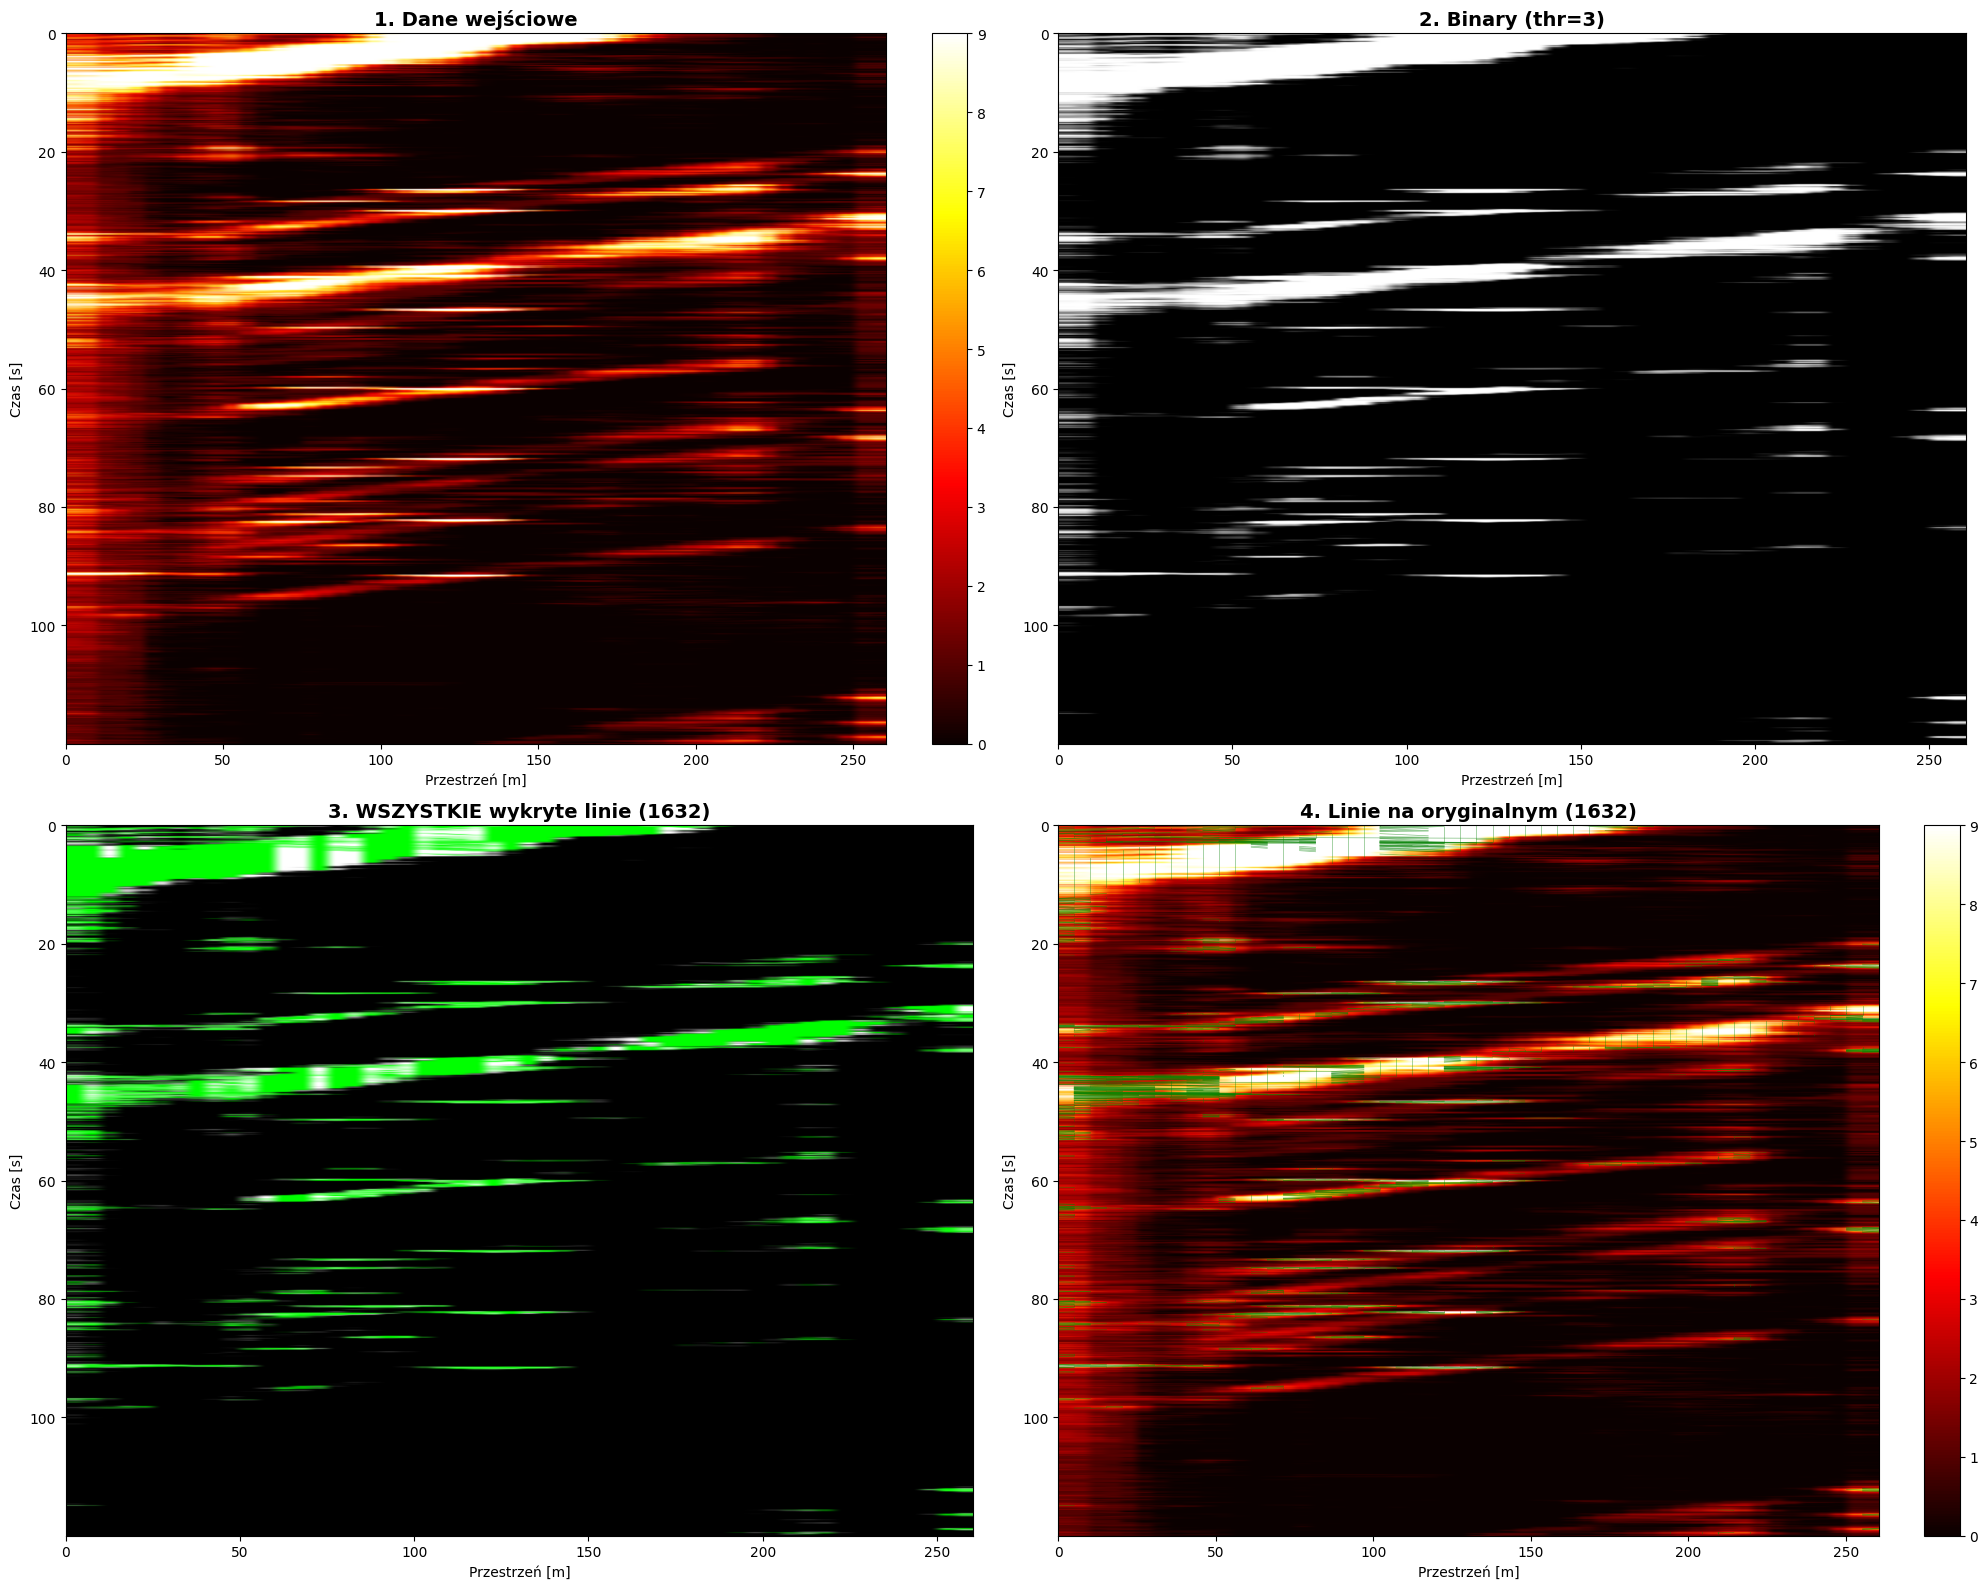

In [31]:
def detect_lines_opencv_show_all(processed_data, dt, dx):
    """
    Pokaż WSZYSTKIE wykryte linie - BEZ FILTRÓW
    """
    print("="*60)
    print("KROK 3: DETEKCJA LINII - POKAZUJĘ WSZYSTKO")
    print("="*60)
    
    import cv2
    
    n_time, n_space = processed_data.shape
    
    print(f"\nParametry:")
    print(f"  Rozmiar: {n_time} × {n_space}")
    print(f"  dt = {dt:.4f} s, dx = {dx:.2f} m")
    
    # Prepare image
    print("\n[1/2] Przygotowanie obrazu...")
    
    data_norm = ((processed_data - np.min(processed_data)) / 
                 (np.max(processed_data) - np.min(processed_data)) * 255).astype(np.uint8)
    
    # NIŻSZY threshold
    threshold_val = np.percentile(data_norm, 90)  # 85% zamiast 93%
    _, binary = cv2.threshold(data_norm, threshold_val, 255, cv2.THRESH_BINARY)
    
    print(f"  Threshold: {threshold_val}")
    print(f"  Pikseli: {np.sum(binary > 0)}")
    
    # Detect lines
    print("\n[2/2] Detekcja linii...")
    
    lines = cv2.HoughLinesP(
        binary,
        rho=1,
        theta=np.pi/180,
        threshold=30,        # NIŻSZY threshold
        minLineLength=15,    # KRÓTSZE linie
        maxLineGap=20        # WIĘKSZY gap
    )
    
    if lines is None:
        print("  ❌ Nie wykryto linii!")
        return
    
    lines = lines[:, 0, :]
    print(f"  ✓ Wykryto {len(lines)} linii")
    
    # Calculate ALL angles and velocities (NO FILTERS!)
    print("\nWYKRYTE LINIE (WSZYSTKIE, pierwsze 30):")
    
    for i, line in enumerate(lines[:30]):
        x1, y1, x2, y2 = line
        
        dx_pixels = x2 - x1
        dy_pixels = y2 - y1
        
        if abs(dx_pixels) > 0.1:
            angle_rad = np.arctan2(dy_pixels, dx_pixels)
            angle_deg = np.rad2deg(angle_rad)
            
            # Velocity
            velocity = (dx_pixels * dx) / (dy_pixels * dt) if abs(dy_pixels) > 0.1 else 999
            
            print(f"  {i+1}. Kąt={angle_deg:6.1f}°, v={velocity:8.1f} m/s ({velocity*3.6:8.1f} km/h), długość={np.sqrt(dx_pixels**2 + dy_pixels**2):.1f}px")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    time_axis = np.arange(n_time) * dt
    space_axis = np.arange(n_space) * dx
    
    # 1. Original
    ax = axes[0]
    low, high = np.percentile(processed_data, [3, 97])
    im1 = ax.imshow(processed_data, aspect='auto', cmap='hot',
                    extent=[0, space_axis[-1], time_axis[-1], 0],
                    norm=Normalize(vmin=low, vmax=high))
    ax.set_title('1. Dane wejściowe', fontweight='bold', fontsize=14)
    ax.set_ylabel('Czas [s]')
    ax.set_xlabel('Przestrzeń [m]')
    plt.colorbar(im1, ax=ax, fraction=0.046)
    
    # 2. Binary
    ax = axes[1]
    ax.imshow(binary, aspect='auto', cmap='gray',
              extent=[0, space_axis[-1], time_axis[-1], 0])
    ax.set_title(f'2. Binary (thr={threshold_val:.0f})', fontweight='bold', fontsize=14)
    ax.set_ylabel('Czas [s]')
    ax.set_xlabel('Przestrzeń [m]')
    
    # 3. ALL lines on binary
    ax = axes[2]
    # Create RGB image to show colored lines
    binary_rgb = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
    
    for line in lines:
        x1, y1, x2, y2 = line
        cv2.line(binary_rgb, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    ax.imshow(binary_rgb, aspect='auto',
              extent=[0, space_axis[-1], time_axis[-1], 0])
    ax.set_title(f'3. WSZYSTKIE wykryte linie ({len(lines)})', fontweight='bold', fontsize=14)
    ax.set_ylabel('Czas [s]')
    ax.set_xlabel('Przestrzeń [m]')
    
    # 4. Lines on original
    ax = axes[3]
    im4 = ax.imshow(processed_data, aspect='auto', cmap='hot',
                    extent=[0, space_axis[-1], time_axis[-1], 0],
                    norm=Normalize(vmin=low, vmax=high))
    
    # Draw ALL lines
    for line in lines:
        x1, y1, x2, y2 = line
        x1_phys = x1 * dx
        x2_phys = x2 * dx
        y1_phys = y1 * dt
        y2_phys = y2 * dt
        
        ax.plot([x1_phys, x2_phys], [y1_phys, y2_phys], 
               'g-', linewidth=0.5, alpha=0.5)
    
    ax.set_title(f'4. Linie na oryginalnym ({len(lines)})', fontweight='bold', fontsize=14)
    ax.set_ylabel('Czas [s]')
    ax.set_xlabel('Przestrzeń [m]')
    plt.colorbar(im4, ax=ax, fraction=0.046)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'lines': lines,
        'binary': binary
    }

# RUN - SHOW EVERYTHING!
detection = detect_lines_opencv_show_all(
    weak_lines['baseline'],
    weak_lines['dt'],
    weak_lines['dx']
)